# ExperimentLoader Demo

This notebook demonstrates how to use `ExperimentLoader` to load and analyze MLflow experiments, including configuration, metrics, checkpoints, and trained models.

## Prerequisites

- **MLflow Access**: Databricks credentials (host/token)
- **S3 Access**: AWS credentials and config.ini for checkpoint loading
- **Dependencies**: Model packages (e.g., transformer-lens)

## Usage Patterns

### Basic Usage
```python
from simplexity.loaders import ExperimentLoader

# Initialize loader
loader = ExperimentLoader.from_mlflow(
    run_id="your-run-id",
    tracking_uri="databricks",
    config_path="path/to/config.ini"  # Optional: for S3 checkpoints
)
```

### Load Different Data Types
```python
# Configuration
config = loader.load_config()

# Metrics (all or filtered)
all_metrics = loader.load_metrics()
val_metrics = loader.load_metrics(pattern="validation/*")

# Checkpoints
checkpoints = loader.list_checkpoints()
latest_step = loader.latest_checkpoint()

# Model (requires checkpoints + dependencies)
model = loader.load_model(step="latest")
```

## Example: Loading a Transformer Experiment

Let's walk through loading a complete experiment.

In [13]:
# --- Setup ---
import os
from simplexity.loaders import ExperimentLoader
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
run_id = "138baafac5a34726ab070bb1be72a83d"
tracking_uri = "databricks"
config_path = os.path.join('..', 'config.ini') if os.path.basename(os.getcwd()) == 'notebooks' else 'config.ini'

print(f"🔍 Run ID: {run_id}")
print(f"📍 Tracking URI: {tracking_uri}")
print(f"🔧 Config: {os.path.abspath(config_path)}")

🔍 Run ID: 138baafac5a34726ab070bb1be72a83d
📍 Tracking URI: databricks
🔧 Config: /Users/adamimos/Documents/GitHub/simplexity/config.ini


In [14]:
# --- Initialize ExperimentLoader ---
loader = ExperimentLoader.from_mlflow(
    run_id=run_id,
    tracking_uri=tracking_uri,
    config_path=config_path
)
print("✅ ExperimentLoader initialized")

✅ ExperimentLoader initialized


In [15]:
# --- 1. Load Configuration ---
print("📋 Loading experiment configuration...")
config = loader.load_config()

print(f"🎯 Experiment: {config.experiment_name}")
print(f"🏃 Run: {config.run_name}")
print(f"🤖 Model: {config.predictive_model.instance._target_}")
print(f"💾 Persistence: {bool(config.persistence)}")

if config.persistence:
    print(f"📦 Persister: {config.persistence.instance._target_}")

📋 Loading experiment configuration...


🎯 Experiment: example_basic_mess3
🏃 Run: 2025-09-09_22-09-10_example_basic_mess3_42
🤖 Model: transformer_lens.HookedTransformer
💾 Persistence: True
📦 Persister: simplexity.persistence.s3_persister.S3Persister.from_config


In [16]:
# --- 2. Load Metrics ---
print("📊 Loading metrics...")

# All metrics
df_all = loader.load_metrics()
print(f"📈 Total metrics: {len(df_all):,} entries")

# Validation metrics only
df_val = loader.load_metrics(pattern="validation/*")
print(f"🎯 Validation metrics: {len(df_val):,} entries")

# Show available metric types
metric_types = sorted(df_all['metric'].unique())
print(f"\n📋 Available metrics ({len(metric_types)} types):")
for metric in metric_types[:8]:  # Show first 8
    count = len(df_all[df_all['metric'] == metric])
    print(f"   • {metric}: {count} points")
if len(metric_types) > 8:
    print(f"   ... and {len(metric_types) - 8} more")

📊 Loading metrics...
📈 Total metrics: 110,102 entries
🎯 Validation metrics: 102 entries

📋 Available metrics (13 types):
   • avg_tokens_per_second: 10000 points
   • grad_norm: 10000 points
   • learning_rate: 10000 points
   • loss: 10000 points
   • max_memory_allocated_gb: 10000 points
   • memory_allocated_gb: 10000 points
   • memory_reserved_gb: 10000 points
   • step_time_seconds: 10000 points
   ... and 5 more


In [17]:
# --- 3. Discover Checkpoints ---
print("🔍 Discovering checkpoints...")

checkpoints = loader.list_checkpoints()
latest = loader.latest_checkpoint()

print(f"📂 Found {len(checkpoints)} checkpoints")
if checkpoints:
    print(f"   Range: {min(checkpoints)} → {max(checkpoints)}")
    print(f"   Latest: {latest}")
    print(f"   All: {checkpoints}")
else:
    print("   ❌ No checkpoints found (S3 access may be required)")

🔍 Discovering checkpoints...
📂 Found 21 checkpoints
   Range: 0 → 10000
   Latest: 10000
   All: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


In [18]:
# --- 4. Load Model ---
print("🤖 Loading trained model...")

try:
    model = loader.load_model(step="latest")
    print(f"✅ Model loaded successfully!")
    print(f"   Type: {type(model).__name__}")
    
    # Get model info
    try:
        param_count = sum(p.numel() for p in model.parameters())
        device = next(model.parameters()).device
        print(f"   Parameters: {param_count:,}")
        print(f"   Device: {device}")
    except Exception:
        print(f"   Model details: [unable to inspect]")
        
except Exception as e:
    print(f"❌ Could not load model: {e}")
    if "transformer_lens" in str(e):
        print("💡 Install missing dependencies: uv add transformer-lens")
    elif "checkpoints" in str(e).lower():
        print("💡 Ensure S3 access is configured in config.ini")

🤖 Loading trained model...
❌ Could not load model: Failed to instantiate predictive model from run config.
Ensure the model's Python package is installed (e.g., `transformer_lens`).
Underlying error: Error in call to target 'transformer_lens.HookedTransformer.HookedTransformer':
RuntimeError('Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, maia, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone device type at start of device string: auto')
full_key: predictive_model.instance
💡 Install missing dependencies: uv add transformer-lens


📈 Plotting validation metrics...


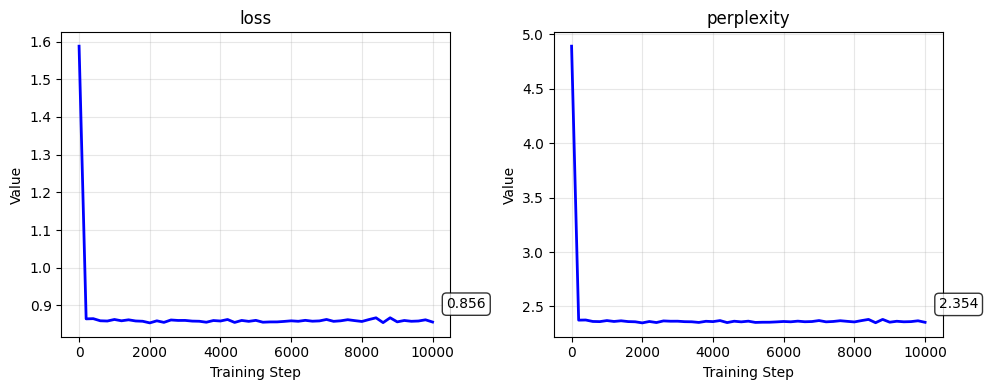

In [19]:
# --- 5. Visualize Training Progress ---
if not df_val.empty:
    print("📈 Plotting validation metrics...")
    
    val_metrics = sorted(df_val['metric'].unique())
    n_metrics = min(len(val_metrics), 3)  # Show up to 3 metrics
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]
    
    for i, metric in enumerate(val_metrics[:n_metrics]):
        data = df_val[df_val['metric'] == metric].sort_values('step')
        axes[i].plot(data['step'], data['value'], 'b-', linewidth=2)
        axes[i].set_title(metric.replace('validation/', ''), fontsize=12)
        axes[i].set_xlabel('Training Step')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)
        
        # Add final value annotation
        if len(data) > 0:
            final_val = data['value'].iloc[-1]
            final_step = data['step'].iloc[-1]
            axes[i].annotate(f'{final_val:.3f}', 
                           xy=(final_step, final_val),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
else:
    print("📈 No validation metrics available for plotting")

## Summary

The `ExperimentLoader` provides a unified interface for loading MLflow experiments:

### ✅ Core Features
- **Configuration**: Reconstructs complete Hydra configs from MLflow artifacts
- **Metrics**: Loads training/validation metrics with pattern filtering
- **Checkpoints**: Discovers available model checkpoints from S3
- **Models**: Reloads trained models with proper device handling

### 🔧 Key Methods
- `ExperimentLoader.from_mlflow(run_id, tracking_uri, config_path)`
- `loader.load_config()` - Get experiment configuration
- `loader.load_metrics(pattern=...)` - Load metrics with optional filtering
- `loader.list_checkpoints()` - Discover available checkpoints
- `loader.load_model(step=...)` - Load trained model

### 📋 Requirements
- MLflow access (Databricks credentials)
- S3 access (AWS credentials + config.ini) for checkpoints
- Model dependencies (e.g., transformer-lens) for model loading